In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:34437")
client

<Client: 'tcp://127.0.0.1:34437' processes=6 threads=6, memory=75.38 GiB>

In [2]:
import numpy as np
import xarray as xr
import dask.array as dsar
import qgutils
import os.path as op
from xhistogram.xarray import histogram as xhist
import matplotlib.pyplot as plt
import matplotlib.colors as clr
%matplotlib inline

In [3]:
ddir = '/bettik/uchidat/qg-ensemble/runs/seas-forcing/10percent/'
sdir = '/bettik/uchidat/qg-ML/'

In [4]:
U = .1
T = 5e5      # seconds
L     = U*T
tau0 = .0001
dt = 5e-2
Rd = 5e4     # Rossby radius (50km)
Re4 = 4e3
# f0 = 8e-5
beta = .5
N = 256*4    # Number of horizontal grids
L0 = 80
H = 5e3
dx = L0/N    # Non-dimensionalized horizontal resolution ((L0*Rd)/N)/Rd
diny = 360
Rom = .025
Ekb = .002*2
ntime = 187

percent = 10
nmemb = 100

In [5]:
def pad_bc(psi, bc='dirichlet'):
    """
    Pad field psi with Dirichlet or Neumann boundary conditions
    Parameters
    ----------
    psi : array [nt,nz (,ny,nx)]
    bc   : 'dirichlet' or 'neumann'
    Returns
    -------
    psi_bc: array [nt,nz (,ny+2,nx+2)]
    """
    nd = psi.ndim
    # only pad horizontal dimensions
    if nd < 4:
        psi = qgutils.pad_bc(psi)
    elif nd == 4:
        psi = np.pad(psi,((0,0),(0,0),(1,1),(1,1)),'constant')
    elif nd == 5:
        psi = np.pad(psi,((0,0),(0,0),(0,0),(1,1),(1,1)),'constant')

    if (bc == 'dirichlet'): 
        psi[...,0,:]  = -psi[...,1,:]
        psi[...,-1,:] = -psi[...,-2,:]
        psi[...,:,0]  = -psi[...,:,1]
        psi[...,:,-1] = -psi[...,:,-2]
    
        # corners
        psi[...,0,0]   = -psi[...,0,1]   - psi[...,1,0]   - psi[...,1,1]
        psi[...,-1,0]  = -psi[...,-1,1]  - psi[...,-2,0]  - psi[...,-2,1]
        psi[...,0,-1]  = -psi[...,1,-1]  - psi[...,0,-2]  - psi[...,1,-2]
        psi[...,-1,-1] = -psi[...,-1,-2] - psi[...,-2,-2] - psi[...,-2,-1]

    elif (bc == 'neumann'): 
        psi[...,0,:]  = psi[...,1,:]
        psi[...,-1,:] = psi[...,-2,:]
        psi[...,:,0]  = psi[...,:,1]
        psi[...,:,-1] = psi[...,:,-2]
    
        # corners
        psi[...,0,0]   = psi[...,1,1]
        psi[...,-1,0]  = psi[...,-2,1]
        psi[...,0,-1]  = psi[...,1,-2]
        psi[...,-1,-1] = psi[...,-2,-2]

    return psi

In [6]:
nmembs = 50
dsb = xr.open_zarr(op.join(ddir, "Mean%2d-Z0_%010d.zarr" % (nmembs,0)))
# psib = xr.DataArray(pad_bc(dsb.p.data), dims=['Yp1','Xp1'],
#                     coords={'Yp1':np.arange(-dx/2,L0+dx,dx),
#                             'Xp1':np.arange(-dx/2,L0+dx,dx)}
#                    )
dsp = xr.open_zarr(op.join(ddir, "Eddy%2d-Z0_%010d.zarr" % (nmembs,0)))
psip = xr.DataArray(pad_bc(dsp.p.data), 
                    dims=['nmemb','Yp1','Xp1'],
                    coords={'nmemb':range(nmembs),
                            'Yp1':np.arange(-dx/2,L0+dx,dx),
                            'Xp1':np.arange(-dx/2,L0+dx,dx)}
                   )

# ub = -psib.isel(Xp1=slice(1,-1)).diff('Yp1') / dx
up = -psip.isel(Xp1=slice(1,-1)).diff('Yp1') / dx
# vb = psib.isel(Yp1=slice(1,-1)).diff('Xp1') / dx
vp = psip.isel(Yp1=slice(1,-1)).diff('Xp1') / dx

In [19]:
ncoars = 4
upP0 = (dsp.ptr0 * (up.isel(Yp1=slice(1,None)).data 
                    + up.isel(Yp1=slice(None,-1)).data
                   )*.5
       ).mean('nmemb').coarsen({'YC':ncoars,'XC':ncoars}).mean()
vpP0 = (dsp.ptr0 * (vp.isel(Xp1=slice(1,None)).data 
                    + vp.isel(Xp1=slice(None,-1)).data
                   )*.5
       ).mean('nmemb').coarsen({'YC':ncoars,'XC':ncoars}).mean()

upP1 = (dsp.ptr1 * (up.isel(Yp1=slice(1,None)).data 
                    + up.isel(Yp1=slice(None,-1)).data
                   )*.5
       ).mean('nmemb').coarsen({'YC':ncoars,'XC':ncoars}).mean()
vpP1 = (dsp.ptr1 * (vp.isel(Xp1=slice(1,None)).data 
                    + vp.isel(Xp1=slice(None,-1)).data
                   )*.5
       ).mean('nmemb').coarsen({'YC':ncoars,'XC':ncoars}).mean()

upP2 = (dsp.ptr2 * (up.isel(Yp1=slice(1,None)).data 
                    + up.isel(Yp1=slice(None,-1)).data
                   )*.5
       ).mean('nmemb').coarsen({'YC':ncoars,'XC':ncoars}).mean()
vpP2 = (dsp.ptr2 * (vp.isel(Xp1=slice(1,None)).data 
                    + vp.isel(Xp1=slice(None,-1)).data
                   )*.5
       ).mean('nmemb').coarsen({'YC':ncoars,'XC':ncoars}).mean()

upP3 = (dsp.ptr3 * (up.isel(Yp1=slice(1,None)).data 
                    + up.isel(Yp1=slice(None,-1)).data
                   )*.5
       ).mean('nmemb').coarsen({'YC':ncoars,'XC':ncoars}).mean()
vpP3 = (dsp.ptr3 * (vp.isel(Xp1=slice(1,None)).data 
                    + vp.isel(Xp1=slice(None,-1)).data
                   )*.5
       ).mean('nmemb').coarsen({'YC':ncoars,'XC':ncoars}).mean()

In [20]:
dsave = upP0.to_dataset(name='uP0')
dsave['vP0'] = vpP0
dsave['uP1'] = upP1
dsave['vP1'] = vpP1
dsave['uP2'] = upP2
dsave['vP2'] = vpP2
dsave['uP3'] = upP3
dsave['vP3'] = vpP3
dsave.chunk({'YC':128,'XC':128}).to_zarr(op.join(ddir,"nC%02d/EddyPtrFlux%2d-Z0_%010d.zarr" 
                                                 % (ncoars,nmembs,0)),
                                         mode='w')
dsave

<xarray.Dataset>
Dimensions:  (XC: 256, YC: 256)
Coordinates:
  * XC       (XC) float64 0.1562 0.4688 0.7812 1.094 ... 78.91 79.22 79.53 79.84
  * YC       (YC) float64 0.1562 0.4688 0.7812 1.094 ... 78.91 79.22 79.53 79.84
    Z        float64 ...
    drF      float64 ...
    t        float32 ...
Data variables:
    uP0      (YC, XC) float32 dask.array<chunksize=(31, 32), meta=np.ndarray>
    vP0      (YC, XC) float32 dask.array<chunksize=(32, 31), meta=np.ndarray>
    uP1      (YC, XC) float32 dask.array<chunksize=(31, 32), meta=np.ndarray>
    vP1      (YC, XC) float32 dask.array<chunksize=(32, 31), meta=np.ndarray>
    uP2      (YC, XC) float32 dask.array<chunksize=(31, 32), meta=np.ndarray>
    vP2      (YC, XC) float32 dask.array<chunksize=(32, 31), meta=np.ndarray>
    uP3      (YC, XC) float32 dask.array<chunksize=(31, 32), meta=np.ndarray>
    vP3      (YC, XC) float32 dask.array<chunksize=(32, 31), meta=np.ndarray>

In [21]:
P0b = xr.DataArray(pad_bc(dsb.ptr0.data), dims=['Yp1','Xp1'],
                   coords={'Yp1':np.arange(-dx/2,L0+dx,dx),
                           'Xp1':np.arange(-dx/2,L0+dx,dx)}
                  )
P1b = xr.DataArray(pad_bc(dsb.ptr1.data), dims=['Yp1','Xp1'],
                   coords={'Yp1':np.arange(-dx/2,L0+dx,dx),
                           'Xp1':np.arange(-dx/2,L0+dx,dx)}
                  )
P2b = xr.DataArray(pad_bc(dsb.ptr2.data), dims=['Yp1','Xp1'],
                   coords={'Yp1':np.arange(-dx/2,L0+dx,dx),
                           'Xp1':np.arange(-dx/2,L0+dx,dx)}
                  )
P3b = xr.DataArray(pad_bc(dsb.ptr3.data), dims=['Yp1','Xp1'],
                   coords={'Yp1':np.arange(-dx/2,L0+dx,dx),
                           'Xp1':np.arange(-dx/2,L0+dx,dx)}
                  )

In [22]:
P0x = P0b.isel(Yp1=slice(1,-1)).diff('Xp1') / dx
P0x = xr.DataArray(.5*(P0x.isel(Xp1=slice(1,None)).data 
                       + P0x.isel(Xp1=slice(None,-1)).data),
                   dims=['YC','XC'], 
                   coords={'YC':dsb.YC,'XC':dsb.XC}
                  ).coarsen({'YC':ncoars,'XC':ncoars}).mean()
P0y = P0b.isel(Xp1=slice(1,-1)).diff('Yp1') / dx
P0y = xr.DataArray(.5*(P0y.isel(Yp1=slice(1,None)).data 
                       + P0y.isel(Yp1=slice(None,-1)).data),
                   dims=['YC','XC'], 
                   coords={'YC':dsb.YC,'XC':dsb.XC}
                  ).coarsen({'YC':ncoars,'XC':ncoars}).mean()

P1x = P1b.isel(Yp1=slice(1,-1)).diff('Xp1') / dx
P1x = xr.DataArray(.5*(P1x.isel(Xp1=slice(1,None)).data 
                       + P1x.isel(Xp1=slice(None,-1)).data),
                   dims=['YC','XC'], 
                   coords={'YC':dsb.YC,'XC':dsb.XC}
                  ).coarsen({'YC':ncoars,'XC':ncoars}).mean()
P1y = P1b.isel(Xp1=slice(1,-1)).diff('Yp1') / dx
P1y = xr.DataArray(.5*(P1y.isel(Yp1=slice(1,None)).data 
                       + P1y.isel(Yp1=slice(None,-1)).data),
                   dims=['YC','XC'], 
                   coords={'YC':dsb.YC,'XC':dsb.XC}
                  ).coarsen({'YC':ncoars,'XC':ncoars}).mean()

P2x = P2b.isel(Yp1=slice(1,-1)).diff('Xp1') / dx
P2x = xr.DataArray(.5*(P2x.isel(Xp1=slice(1,None)).data 
                       + P2x.isel(Xp1=slice(None,-1)).data),
                   dims=['YC','XC'], 
                   coords={'YC':dsb.YC,'XC':dsb.XC}
                  ).coarsen({'YC':ncoars,'XC':ncoars}).mean()
P2y = P2b.isel(Xp1=slice(1,-1)).diff('Yp1') / dx
P2y = xr.DataArray(.5*(P2y.isel(Yp1=slice(1,None)).data 
                       + P2y.isel(Yp1=slice(None,-1)).data),
                   dims=['YC','XC'], 
                   coords={'YC':dsb.YC,'XC':dsb.XC}
                  ).coarsen({'YC':ncoars,'XC':ncoars}).mean()

P3x = P3b.isel(Yp1=slice(1,-1)).diff('Xp1') / dx
P3x = xr.DataArray(.5*(P3x.isel(Xp1=slice(1,None)).data 
                       + P3x.isel(Xp1=slice(None,-1)).data),
                   dims=['YC','XC'], 
                   coords={'YC':dsb.YC,'XC':dsb.XC}
                  ).coarsen({'YC':ncoars,'XC':ncoars}).mean()
P3y = P3b.isel(Xp1=slice(1,-1)).diff('Yp1') / dx
P3y = xr.DataArray(.5*(P3y.isel(Yp1=slice(1,None)).data 
                       + P3y.isel(Yp1=slice(None,-1)).data),
                   dims=['YC','XC'], 
                   coords={'YC':dsb.YC,'XC':dsb.XC}
                  ).coarsen({'YC':ncoars,'XC':ncoars}).mean()
dsave = P0x.to_dataset(name='P0x')
dsave['P0y'] = P0y
dsave['P1x'] = P1x
dsave['P1y'] = P1y
dsave['P2x'] = P2x
dsave['P2y'] = P2y
dsave['P3x'] = P3x
dsave['P3y'] = P3y
dsave.chunk({'YC':128,'XC':128}).to_zarr(op.join(ddir,'nC%02d/GradFlux%2d-Z0_%010d.zarr' 
                                                 % (ncoars,nmembs,0)), 
                                         mode='w')

In [33]:
ncoars = 4
nmembs = 50
dsp1 = xr.open_zarr(op.join(ddir,"nC%02d/EddyPtrFlux%2d-Z0_%010d.zarr" 
                            % (ncoars,nmembs,0))
                   )
dsg = xr.open_zarr(op.join(ddir,'nC%02d/GradFlux%2d-Z0_%010d.zarr' 
                           % (ncoars,nmembs,0))
                  )
dsp1

<xarray.Dataset>
Dimensions:  (XC: 256, YC: 256)
Coordinates:
  * XC       (XC) float64 0.1562 0.4688 0.7812 1.094 ... 78.91 79.22 79.53 79.84
  * YC       (YC) float64 0.1562 0.4688 0.7812 1.094 ... 78.91 79.22 79.53 79.84
    Z        float64 ...
    drF      float64 ...
    t        float32 ...
Data variables:
    uP0      (YC, XC) float32 dask.array<chunksize=(128, 128), meta=np.ndarray>
    uP1      (YC, XC) float32 dask.array<chunksize=(128, 128), meta=np.ndarray>
    uP2      (YC, XC) float32 dask.array<chunksize=(128, 128), meta=np.ndarray>
    uP3      (YC, XC) float32 dask.array<chunksize=(128, 128), meta=np.ndarray>
    vP0      (YC, XC) float32 dask.array<chunksize=(128, 128), meta=np.ndarray>
    vP1      (YC, XC) float32 dask.array<chunksize=(128, 128), meta=np.ndarray>
    vP2      (YC, XC) float32 dask.array<chunksize=(128, 128), meta=np.ndarray>
    vP3      (YC, XC) float32 dask.array<chunksize=(128, 128), meta=np.ndarray>

In [34]:
def _dot2D(self, other):
    func = np.dot(self[0,0], other[0,0])
    
    return func[np.newaxis,np.newaxis,:,:]

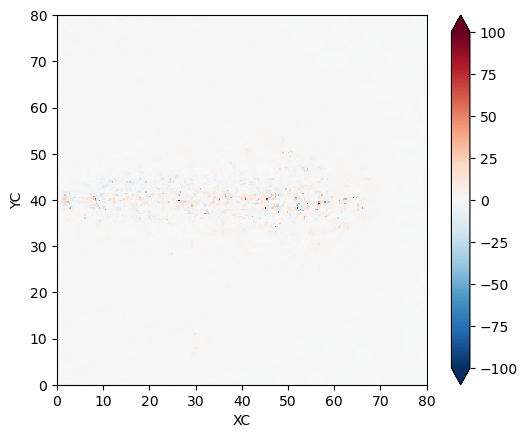

In [35]:
# xlim = [280,340]
ncoars = 0
tt = 0
# lstart = sstart + 2

uP0 = dsp1.uP0
vP0 = dsp1.vP0
uP1 = dsp1.uP1
vP1 = dsp1.vP1
uP2 = dsp1.uP2
vP2 = dsp1.vP2
uP3 = dsp1.uP3
vP3 = dsp1.vP3

#################################
u0_norm = (uP0 * np.nanmedian(np.sqrt(dsg.P0x**2 + dsg.P0y**2),
                                      axis=(-2,-1))**-1)
v0_norm = (vP0 * np.nanmedian(np.sqrt(dsg.P0x**2 + dsg.P0y**2),
                                      axis=(-2,-1))**-1)
u1_norm = (uP1 * np.nanmedian(np.sqrt(dsg.P1x**2 + dsg.P1y**2),
                                      axis=(-2,-1))**-1)
v1_norm = (vP1 * np.nanmedian(np.sqrt(dsg.P1x**2 + dsg.P1y**2),
                                      axis=(-2,-1))**-1)
u2_norm = (uP2 * np.nanmedian(np.sqrt(dsg.P2x**2 + dsg.P2y**2),
                                      axis=(-2,-1))**-1)
v2_norm = (vP2 * np.nanmedian(np.sqrt(dsg.P2x**2 + dsg.P2y**2),
                                      axis=(-2,-1))**-1)
u3_norm = (uP3 * np.nanmedian(np.sqrt(dsg.P3x**2 + dsg.P3y**2),
                                      axis=(-2,-1))**-1)
v3_norm = (vP3 * np.nanmedian(np.sqrt(dsg.P3x**2 + dsg.P3y**2),
                                      axis=(-2,-1))**-1)

P0x_norm = (dsg.P0x
            * np.nanmedian(np.sqrt(dsg.P0x**2 + dsg.P0y**2), 
                                       axis=(-2,-1))**-1)
P0y_norm = (dsg.P0y
            * np.nanmedian(np.sqrt(dsg.P0x**2 + dsg.P0y**2), 
                                       axis=(-2,-1))**-1)
P1x_norm = (dsg.P1x 
            * np.nanmedian(np.sqrt(dsg.P1x**2 + dsg.P1y**2), 
                                       axis=(-2,-1))**-1)
P1y_norm = (dsg.P1y
            * np.nanmedian(np.sqrt(dsg.P1x**2 + dsg.P1y**2), 
                                       axis=(-2,-1))**-1)
P2x_norm = (dsg.P2x
            * np.nanmedian(np.sqrt(dsg.P2x**2 + dsg.P2y**2), 
                                       axis=(-2,-1))**-1)
P2y_norm = (dsg.P2y
            * np.nanmedian(np.sqrt(dsg.P2x**2 + dsg.P2y**2), 
                                       axis=(-2,-1))**-1)
P3x_norm = (dsg.P3x 
            * np.nanmedian(np.sqrt(dsg.P3x**2 + dsg.P3y**2), 
                                       axis=(-2,-1))**-1)
P3y_norm = (dsg.P3y 
            * np.nanmedian(np.sqrt(dsg.P3x**2 + dsg.P3y**2), 
                                       axis=(-2,-1))**-1)

#################################
K = xr.DataArray(np.ones((len(uP0.YC.data),
                          len(uP0.XC.data),
                          2,2))*np.nan,
                 dims=['YC','XC','row','col'],
                 coords={'YC':uP0.YC.data,
                         'XC':uP0.XC.data}
                )

G = xr.DataArray(np.zeros((len(uP0.YC.data),
                           len(uP0.XC.data),
                           4,2)),
                 dims=['YC','XC','row','col']
                )
G[:,:,0,0] = -P0x_norm
G[:,:,0,1] = -P0y_norm
G[:,:,1,0] = -P1x_norm
G[:,:,1,1] = -P1y_norm
G[:,:,2,0] = -P2x_norm
G[:,:,2,1] = -P2y_norm
G[:,:,3,0] = -P3x_norm
G[:,:,3,1] = -P3y_norm

#         G = G.fillna(0.)

invG = xr.DataArray(dsar.map_blocks(np.linalg.pinv, 
                                    G.chunk({'YC':1,'XC':1}).data
                                   ).compute(),
                    dims=['YC','XC','row','col']
                   )
del G

F = xr.DataArray(np.zeros((len(uP0.YC.data),
                           len(uP0.XC.data),
                           4,2)),
                 dims=['YC','XC','row','col']
                )
F[:,:,0,0] = u0_norm
F[:,:,0,1] = v0_norm
F[:,:,1,0] = u1_norm
F[:,:,1,1] = v1_norm
F[:,:,2,0] = u2_norm
F[:,:,2,1] = v2_norm
F[:,:,3,0] = u3_norm
F[:,:,3,1] = v3_norm

#         F = F.fillna(0.)

K[:] = dsar.map_blocks(_dot2D, invG.chunk({'YC':1,'XC':1}).data, 
                       F.chunk({'YC':1,'XC':1}).data,
                       chunks=(1,1,2,2)
                      ).compute()
fig, ax = plt.subplots()
K[:,:,0,0].plot(ax=ax, vmax=1e2)
ax.set_aspect('equal')
plt.show()

del F, invG
#         print(l)

K.chunk({'YC':128,'XC':128}).to_dataset(name='K').to_zarr(op.join(ddir,
                                                   'Diff-tensor/nC%02d/%2d-membs/%010d.zarr'
                                                                  % (ncoars,nmembs,tt)),
                                                          mode='w')

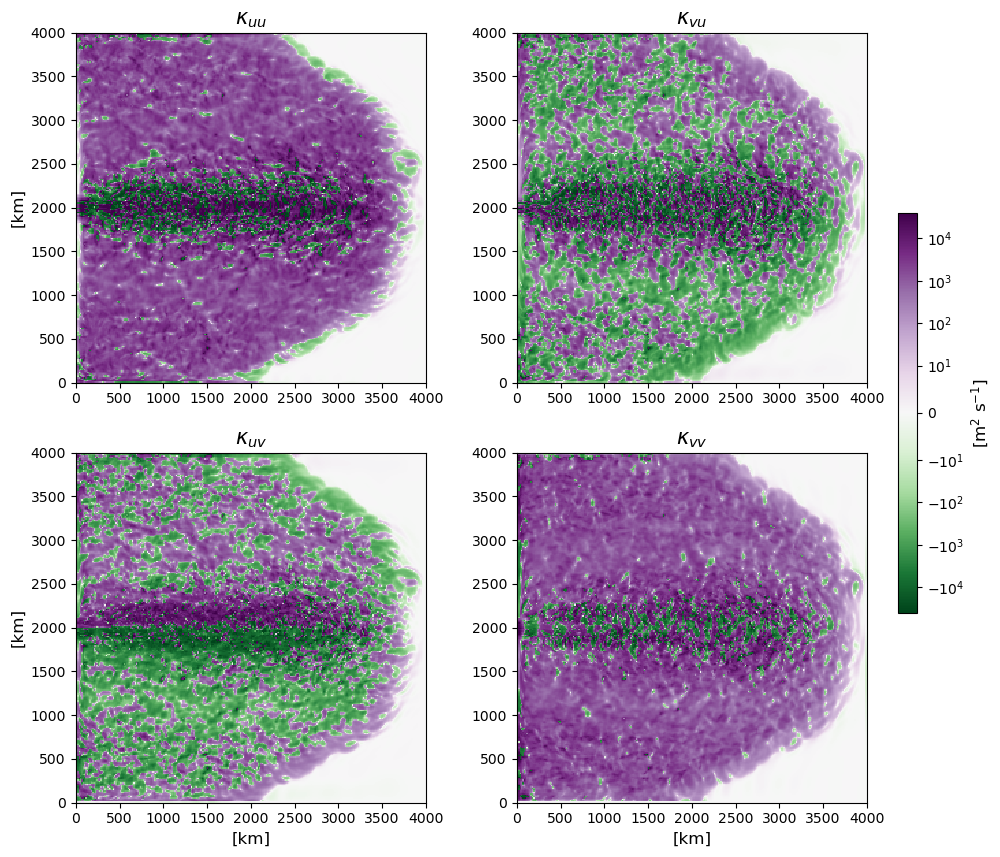

In [36]:
fig, axes = plt.subplots(figsize=(11,10), nrows=2, ncols=2)

im = axes[0,0].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3, K[...,0,0]*U*L,
                          cmap='PRGn_r', 
                          norm=clr.SymLogNorm(vmax=4e4, vmin=-4e4, linthresh=1e1),
                          rasterized=True
                         )
axes[1,0].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3, K[...,1,0]*U*L,
                     cmap='PRGn_r', 
                     norm=clr.SymLogNorm(vmax=4e4, vmin=-4e4, linthresh=1e1),
                     rasterized=True
                    )
axes[0,1].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3, K[...,0,1]*U*L,
                     cmap='PRGn_r', 
                     norm=clr.SymLogNorm(vmax=4e4, vmin=-4e4, linthresh=1e1),
                     rasterized=True
                    )
axes[1,1].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3, K[...,1,1]*U*L,
                     cmap='PRGn_r', 
                     norm=clr.SymLogNorm(vmax=4e4, vmin=-4e4, linthresh=1e1),
                     rasterized=True
                    )

axes[0,0].set_aspect(1)
axes[1,0].set_aspect(1)
axes[0,1].set_aspect(1)
axes[1,1].set_aspect(1)

axes[0,0].set_title(r"$\kappa_{uu}$", fontsize=15)
axes[1,0].set_title(r"$\kappa_{uv}$", fontsize=15)
axes[0,1].set_title(r"$\kappa_{vu}$", fontsize=15)
axes[1,1].set_title(r"$\kappa_{vv}$", fontsize=15)

axes[0,0].set_ylabel(r"[km]", fontsize=12)
axes[1,0].set_ylabel(r"[km]", fontsize=12)
axes[1,0].set_xlabel(r"[km]", fontsize=12)
axes[1,1].set_xlabel(r"[km]", fontsize=12)

fig.subplots_adjust(right=0.86, hspace=.2)
cbax = fig.add_axes([.88, .3, .018, .4])
cbar = fig.colorbar(im, cax=cbax)
cbar.set_label(r"[m$^2$ s$^{-1}$]", fontsize=12)

plt.savefig(op.join(sdir,'Figs/Kappa%2d_Z=0_%010d.pdf' % (nmembs,0)))

In [11]:
ncoars = 4
tt = 0
K12 = xr.open_zarr(op.join(ddir, 'Diff-tensor/nC%02d/%2d-membs/%010d.zarr' 
                           % (ncoars,12,tt))).K
K25 = xr.open_zarr(op.join(ddir, 'Diff-tensor/nC%02d/%2d-membs/%010d.zarr'
                           % (ncoars,25,tt))).K
K50 = xr.open_zarr(op.join(ddir, 'Diff-tensor/nC%02d/%2d-membs/%010d.zarr' 
                           % (ncoars,50,tt))).K
K = xr.open_zarr(op.join(sdir,'Diff-tensor/nC%02d/%010d.zarr'
                         % (ncoars,tt))).K.isel(Z=0)

/tmp/ipykernel_14643/2833071094.py:9: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  K = xr.open_zarr(op.join(sdir,'Diff-tensor/nC%02d/%010d.zarr'


In [12]:
bins = np.concatenate((-np.logspace(5, 1, 2000)[:-1],
                       np.concatenate((np.linspace(-1e1,1e1,101),
                                       np.logspace(1, 5, 2000)[1:]
                                      ))
                      ))
# bins = np.linspace(-1e5,1e5,10000)
h12_00 = xhist(K12[...,0,0]*U*L, bins=[bins], density=False)
h12_01 = xhist(K12[...,0,1]*U*L, bins=[bins], density=False)
h12_10 = xhist(K12[...,1,0]*U*L, bins=[bins], density=False)
h12_11 = xhist(K12[...,1,1]*U*L, bins=[bins], density=False)

h25_00 = xhist(K25[...,0,0]*U*L, bins=[bins], density=False)
h25_01 = xhist(K25[...,0,1]*U*L, bins=[bins], density=False)
h25_10 = xhist(K25[...,1,0]*U*L, bins=[bins], density=False)
h25_11 = xhist(K25[...,1,1]*U*L, bins=[bins], density=False)

h50_00 = xhist(K50[...,0,0]*U*L, bins=[bins], density=False)
h50_01 = xhist(K50[...,0,1]*U*L, bins=[bins], density=False)
h50_10 = xhist(K50[...,1,0]*U*L, bins=[bins], density=False)
h50_11 = xhist(K50[...,1,1]*U*L, bins=[bins], density=False)

h_00 = xhist(K[...,0,0]*U*L, bins=[bins], density=False)
h_01 = xhist(K[...,0,1]*U*L, bins=[bins], density=False)
h_10 = xhist(K[...,1,0]*U*L, bins=[bins], density=False)
h_11 = xhist(K[...,1,1]*U*L, bins=[bins], density=False)

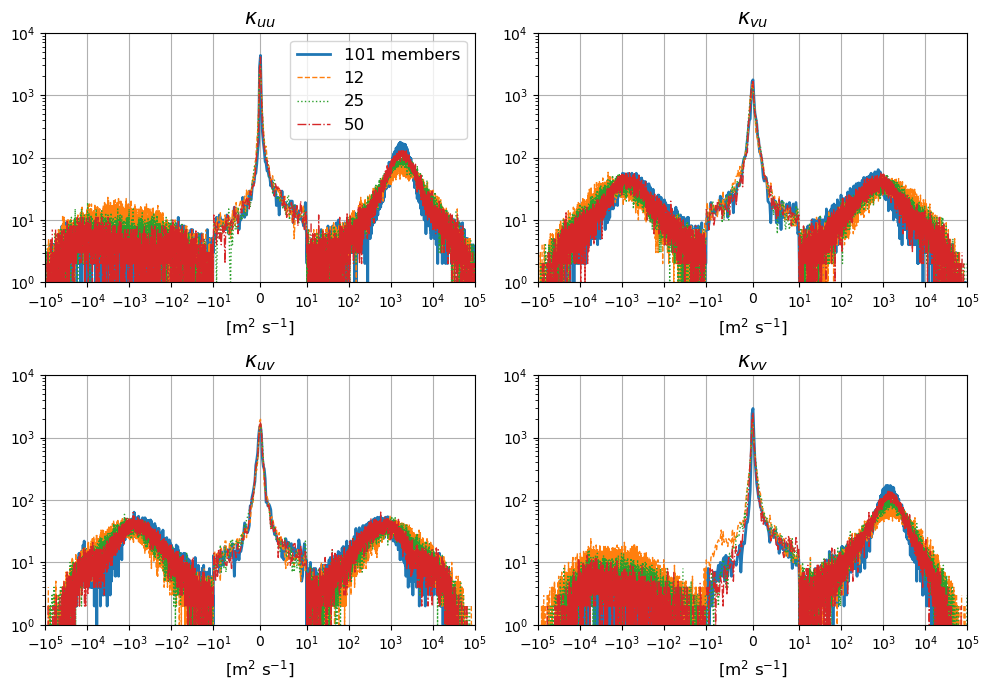

In [18]:
fig, axes = plt.subplots(figsize=(10,7), nrows=2, ncols=2)
fig.set_tight_layout(True)

axes[0,0].plot(.5*(bins[1:]+bins[:-1]), h_00.where(h_00>0), lw=2, label=r"101 members")
axes[0,1].plot(.5*(bins[1:]+bins[:-1]), h_01.where(h_01>0), lw=2)
axes[1,0].plot(.5*(bins[1:]+bins[:-1]), h_10.where(h_10>0), lw=2)
axes[1,1].plot(.5*(bins[1:]+bins[:-1]), h_11.where(h_11>0), lw=2)

axes[0,0].plot(.5*(bins[1:]+bins[:-1]), h12_00.where(h12_00>0), ls='--', lw=1, label=r"12")
axes[0,1].plot(.5*(bins[1:]+bins[:-1]), h12_01.where(h12_01>0), ls='--', lw=1)
axes[1,0].plot(.5*(bins[1:]+bins[:-1]), h12_10.where(h12_10>0), ls='--', lw=1)
axes[1,1].plot(.5*(bins[1:]+bins[:-1]), h12_11.where(h12_11>0), ls='--', lw=1)

axes[0,0].plot(.5*(bins[1:]+bins[:-1]), h25_00.where(h25_00>0), ls=':', lw=1, label=r"25")
axes[0,1].plot(.5*(bins[1:]+bins[:-1]), h25_01.where(h25_01>0), ls=':', lw=1)
axes[1,0].plot(.5*(bins[1:]+bins[:-1]), h25_10.where(h25_10>0), ls=':', lw=1)
axes[1,1].plot(.5*(bins[1:]+bins[:-1]), h25_11.where(h25_11>0), ls=':', lw=1)

axes[0,0].plot(.5*(bins[1:]+bins[:-1]), h50_00.where(h50_00>0), ls='-.', lw=1, label=r"50")
axes[0,1].plot(.5*(bins[1:]+bins[:-1]), h50_01.where(h50_01>0), ls='-.', lw=1)
axes[1,0].plot(.5*(bins[1:]+bins[:-1]), h50_10.where(h50_10>0), ls='-.', lw=1)
axes[1,1].plot(.5*(bins[1:]+bins[:-1]), h50_11.where(h50_11>0), ls='-.', lw=1)


axes[0,0].set_xscale('symlog', linthresh=1e1)
axes[0,1].set_xscale('symlog', linthresh=1e1)
axes[1,0].set_xscale('symlog', linthresh=1e1)
axes[1,1].set_xscale('symlog', linthresh=1e1)

axes[0,0].set_yscale('log')
axes[0,1].set_yscale('log')
axes[1,0].set_yscale('log')
axes[1,1].set_yscale('log')

axes[0,0].set_xlabel(r'[m$^2$ s$^{-1}$]', fontsize=12)
axes[0,1].set_xlabel(r'[m$^2$ s$^{-1}$]', fontsize=12)
axes[1,0].set_xlabel(r'[m$^2$ s$^{-1}$]', fontsize=12)
axes[1,1].set_xlabel(r'[m$^2$ s$^{-1}$]', fontsize=12)

axes[0,0].set_title(r"$\kappa_{uu}$", fontsize=15)
axes[1,0].set_title(r"$\kappa_{uv}$", fontsize=15)
axes[0,1].set_title(r"$\kappa_{vu}$", fontsize=15)
axes[1,1].set_title(r"$\kappa_{vv}$", fontsize=15)

axes[0,0].set_xlim([-1e5,1e5])
axes[0,1].set_xlim([-1e5,1e5])
axes[1,0].set_xlim([-1e5,1e5])
axes[1,1].set_xlim([-1e5,1e5])

axes[0,0].set_ylim([1e0,1e4])
axes[0,1].set_ylim([1e0,1e4])
axes[1,0].set_ylim([1e0,1e4])
axes[1,1].set_ylim([1e0,1e4])

axes[0,0].grid(True)
axes[0,1].grid(True)
axes[1,0].grid(True)
axes[1,1].grid(True)

axes[0,0].legend(loc='upper right', fontsize=12)

plt.savefig(op.join(sdir,'Figs/K_histogram.pdf'))